In [1]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import cv2
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import logging
import sys
from pathlib import Path
project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [2]:
log_file = "binary_cnn_training.log"
logging.basicConfig(
    level=logging.INFO,  # Change to DEBUG for even more detail
    format="%(asctime)s %(levelname)s: %(message)s",
    handlers=[
        logging.FileHandler(log_file, mode="a"),  # Append mode
        logging.StreamHandler()
    ]
)
logger = logging.getLogger()

In [3]:
class Config:
    # Directory paths
    DATA_DIR = project_root / "data/resized_and_split/"
    WEIGHTS_DIR = project_root / "weights"
    
    # Image parameters
    IMG_SIZE = 224  # Using 224x224 images
    
    # Training hyperparameters
    BATCH_SIZE = 64
    LR = 1e-3
    EPOCHS = 15
    KFOLDS = 2  # Number of folds for K-fold cross-validation
    
    # Device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 20
    
    # Random seed for reproducibility
    RANDOM_SEED = 42

# Set seeds for reproducibility
random.seed(Config.RANDOM_SEED)
np.random.seed(Config.RANDOM_SEED)
torch.manual_seed(Config.RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(Config.RANDOM_SEED)

logger.info("Configuration:")
logger.info(f"IMG_SIZE: {Config.IMG_SIZE}, BATCH_SIZE: {Config.BATCH_SIZE}, LR: {Config.LR}, EPOCHS: {Config.EPOCHS}, KFOLDS: {Config.KFOLDS}")
logger.info(f"Device: {Config.device}")

2025-02-01 00:33:42,506 INFO: Configuration:
2025-02-01 00:33:42,507 INFO: IMG_SIZE: 224, BATCH_SIZE: 64, LR: 0.001, EPOCHS: 15, KFOLDS: 2
2025-02-01 00:33:42,507 INFO: Device: cuda


In [4]:
class BinaryImageDataset(Dataset):
    """
    Custom Dataset for binary classification.
    Assumes a directory structure:
        data_dir/
          positive/ -> images with label 1
          negative/ -> images with label 0
    """
    def __init__(self, data_dir, transform=None):
        self.data_dir = Path(data_dir)
        self.transform = transform
        self.samples = []  # list of tuples: (image_path, label)
        
        # Load positive samples
        pos_dir = self.data_dir / "positive"
        if pos_dir.exists():
            for fname in os.listdir(pos_dir):
                if self._is_image_file(fname):
                    self.samples.append((pos_dir / fname, 1))
        else:
            logger.warning(f"Directory {pos_dir} does not exist.")
        
        # Load negative samples
        neg_dir = self.data_dir / "negative"
        if neg_dir.exists():
            for fname in os.listdir(neg_dir):
                if self._is_image_file(fname):
                    self.samples.append((neg_dir / fname, 0))
        else:
            logger.warning(f"Directory {neg_dir} does not exist.")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        try:
            img = cv2.imread(str(img_path), cv2.IMREAD_COLOR)
            if img is None:
                raise ValueError(f"Image {img_path} could not be read.")
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            logger.error(f"Error reading {img_path}: {e}")
            img = np.zeros((Config.IMG_SIZE, Config.IMG_SIZE, 3), dtype=np.uint8)
        
        if self.transform:
            img = self.transform(img)
        
        return img, torch.tensor(label, dtype=torch.float32)
    
    def _is_image_file(self, filename):
        return filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))


In [5]:
class ImprovedBinaryCNN(nn.Module):
    def __init__(self, num_channels=3):
        super(ImprovedBinaryCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.act1  = nn.LeakyReLU(0.1)
        
        # Convolutional Block 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.act2  = nn.LeakyReLU(0.1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 224 -> 112
        
        # Convolutional Block 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.act3  = nn.LeakyReLU(0.1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # 112 -> 56
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))  # 56x56 -> 1x1
        
        # Fully Connected Layers
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(128, 1)  # 128 channels -> 1 logit

    def forward(self, x):
        x = self.act1(self.bn1(self.conv1(x)))
        x = self.act2(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.act3(self.bn3(self.conv3(x)))
        x = self.pool2(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x  # raw logits


In [6]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=Config.EPOCHS):
    model = model.to(device)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        epoch_bar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        
        for images, labels in epoch_bar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            epoch_bar.set_postfix({
                "batch_loss": f"{loss.item():.4f}",
                "batch_acc": f"{(preds == labels).float().mean().item():.4f}"
            })
        
        train_epoch_loss = running_loss / total
        train_epoch_acc = correct / total
        
        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * images.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_epoch_loss = val_running_loss / val_total
        val_epoch_acc = val_correct / val_total
        
        train_losses.append(train_epoch_loss)
        val_losses.append(val_epoch_loss)
        train_accs.append(train_epoch_acc)
        val_accs.append(val_epoch_acc)
        
        logger.info(f"Epoch [{epoch+1}/{num_epochs}] "
                    f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} | "
                    f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
        
        scheduler.step()
    
    return (train_losses, val_losses, train_accs, val_accs)


In [7]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [8]:
def save_model(model, history, model_name):
    Config.WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
    model_path = Config.WEIGHTS_DIR / f"{model_name}_model.pth"
    torch.save(model.state_dict(), model_path)
    
    train_losses, val_losses, train_accs, val_accs = history
    history_path = Config.WEIGHTS_DIR / f"{model_name}_history.npz"
    np.savez(history_path,
             train_losses=train_losses,
             val_losses=val_losses,
             train_accs=train_accs,
             val_accs=val_accs)
    logger.info(f"Saved model and history to:\n{model_path}\n{history_path}")


In [9]:
def plot_history(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Acc', marker='o')
    plt.plot(epochs, val_accs, label='Val Acc', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [10]:
def load_history(history_path):
    history = np.load(history_path)
    train_losses = history["train_losses"]
    val_losses = history["val_losses"]
    train_accs = history["train_accs"]
    val_accs = history["val_accs"]
    return train_losses, val_losses, train_accs, val_accs


In [11]:
"""target_class = "elephant"
    

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = Config.DATA_DIR / target_class / "train"
val_dir = Config.DATA_DIR / target_class / "validation"

train_dataset = BinaryImageDataset(train_dir, transform=transform)
val_dataset = BinaryImageDataset(val_dir, transform=transform)

logger.info(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.num_workers)

model = ImprovedBinaryCNN().to(Config.device)
logger.info(f"Model architecture:\n{model}")

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)


history = train_model(model, train_loader, val_loader, criterion, optimizer, Config.device, num_epochs=Config.EPOCHS)

model_name = f"{target_class}_simple"
save_model(model, history, model_name)"""

'target_class = "elephant"\n    \n\ntransform = transforms.Compose([\n    transforms.ToPILImage(),\n    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485, 0.456, 0.406],\n                         std=[0.229, 0.224, 0.225])\n])\n\ntrain_dir = Config.DATA_DIR / target_class / "train"\nval_dir = Config.DATA_DIR / target_class / "validation"\n\ntrain_dataset = BinaryImageDataset(train_dir, transform=transform)\nval_dataset = BinaryImageDataset(val_dir, transform=transform)\n\nlogger.info(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")\n\n\ntrain_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=Config.num_workers)\nval_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.num_workers)\n\nmodel = ImprovedBinaryCNN().to(Config.device)\nlogger.info(f"Model architecture:\n{model}")\n\ncriterion = nn.BCEWithLogitsLoss

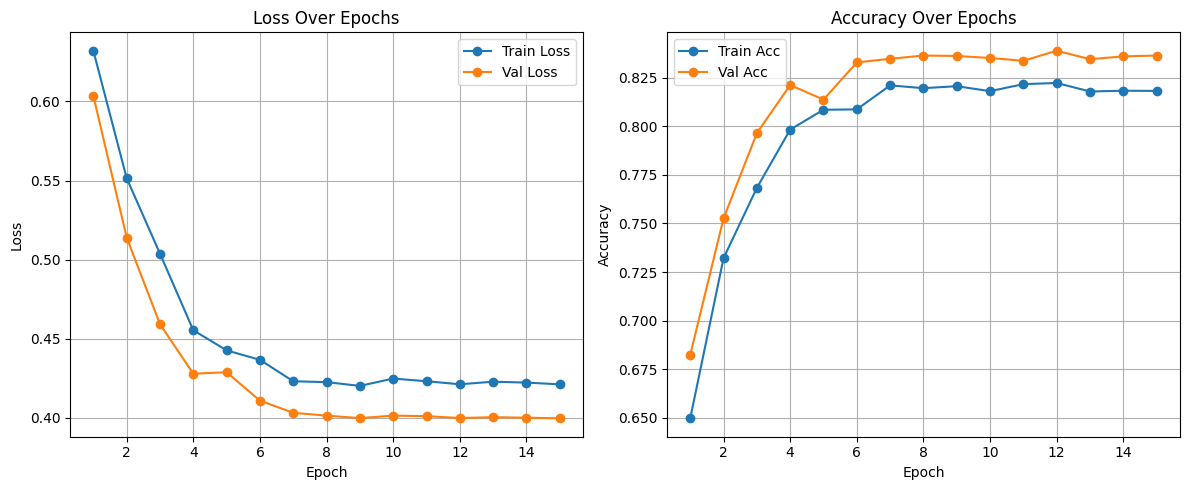

In [12]:
history_path = str(Config.WEIGHTS_DIR / "elephant_simple_history.npz")
train_losses, val_losses, train_accs, val_accs = load_history(history_path)
plot_history(train_losses, val_losses, train_accs, val_accs)

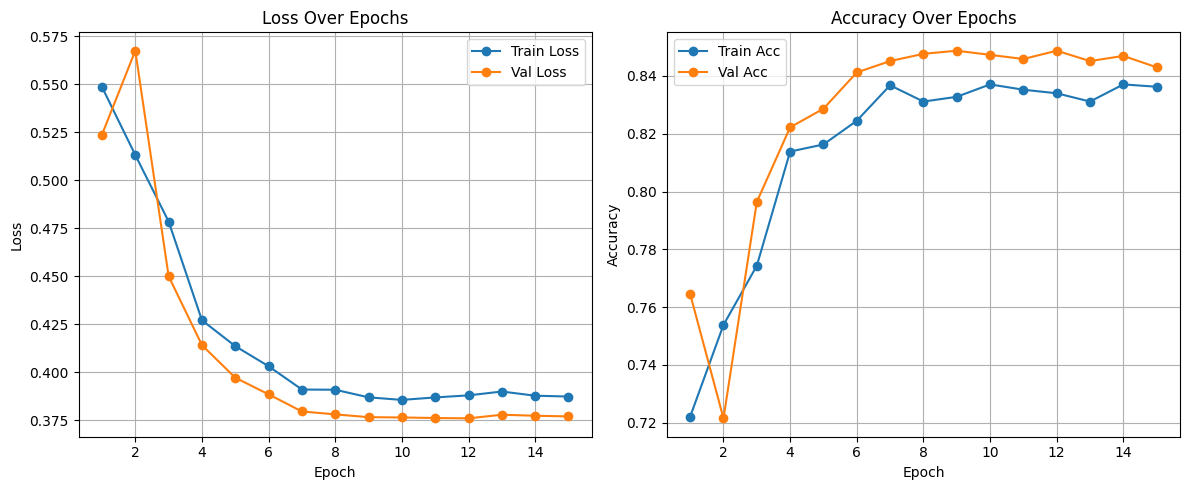

In [13]:
history_path = str(Config.WEIGHTS_DIR / "tiger_simple_history.npz")
train_losses, val_losses, train_accs, val_accs = load_history(history_path)
plot_history(train_losses, val_losses, train_accs, val_accs)

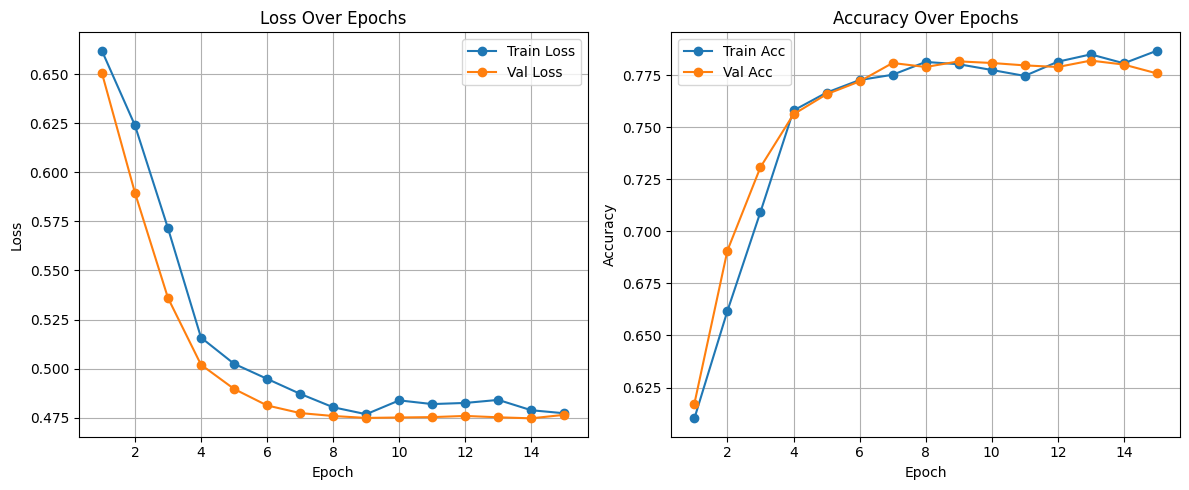

In [14]:
history_path = str(Config.WEIGHTS_DIR / "fox_simple_history.npz")
train_losses, val_losses, train_accs, val_accs = load_history(history_path)
plot_history(train_losses, val_losses, train_accs, val_accs)